In [1]:
!pip install -q -U keras-tuner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import kerastuner as kt
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.layers import BatchNormalization
from keras.layers.wrappers import Bidirectional

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data = pd.read_csv('/content/gdrive/My Drive/TSLA.csv', date_parser = True)

In [5]:
data.shape

(2704, 7)

In [6]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_test = data[data['Date']>='2020-01-01'].copy()

In [7]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)
data_test = data_test.drop(['Date', 'Adj Close'], axis = 1)

In [8]:
data_test[-1:]

,Open,High,Low,Close,Volume
2703,613.0,645.5,609.5,640.390015,39150700


In [9]:
day_interval=60

In [10]:
past_30_days = data_training.tail(day_interval)
df = past_30_days.append(data_test)

In [11]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [12]:
train_size = data_training.shape[0]
print(train_size)

2394


In [13]:
X_train = []
y_train = []

for i in range(day_interval, data_training.shape[0]):
    X_train.append(data_training[i-day_interval:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape

(2334, 60, 5)

In [15]:
y_train.shape

(2334,)

In [16]:
def model_builder(hp):
  model = keras.Sequential()

  hp_units = hp.Int('units', min_value=60, max_value=120, step=60)

  model.add(keras.layers.LSTM(units=hp_units, unroll= True, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(PReLU())

  #model.add(keras.layers.LSTM(units=hp_units, unroll= True, return_sequences = True))
  #model.add(PReLU())

  model.add(keras.layers.LSTM(units=hp_units))
  model.add(PReLU())

  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=['mse'])

  return model

In [17]:
tuner = kt.Hyperband(model_builder,
            objective='val_loss',
            max_epochs=10,
            factor=3,
            directory='my_dir',
            project_name='stock_predv1')

INFO:tensorflow:Reloading Oracle from existing project my_dir/stock_predv1/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/stock_predv1/tuner0.json


In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 60 and the optimal learning rate for the optimizer
is 0.001.



In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch))
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
59/59 [==============================] - 13s 45ms/step - loss: 0.0198 - mse: 0.0366 - val_loss: 0.0011 - val_mse: 0.0031
Epoch 2/50
59/59 [==============================] - 1s 21ms/step - loss: 3.5754e-04 - mse: 8.4271e-04 - val_loss: 9.2761e-04 - val_mse: 0.0027
Epoch 3/50
59/59 [==============================] - 1s 21ms/step - loss: 2.9189e-04 - mse: 6.6449e-04 - val_loss: 0.0012 - val_mse: 0.0034
Epoch 4/50
59/59 [==============================] - 1s 21ms/step - loss: 3.4423e-04 - mse: 7.9057e-04 - val_loss: 8.3923e-04 - val_mse: 0.0024
Epoch 5/50
59/59 [==============================] - 1s 20ms/step - loss: 2.7313e-04 - mse: 6.3641e-04 - val_loss: 8.8791e-04 - val_mse: 0.0026
Epoch 6/50
59/59 [==============================] - 1s 21ms/step - loss: 2.3009e-04 - mse: 5.2952e-04 - val_loss: 6.6191e-04 - val_mse: 0.0019
Epoch 7/50
59/59 [==============================] - 1s 21ms/step - loss: 2.5154e-04 - mse: 5.8021e-04 - val_loss: 6.4265e-04 - val_mse: 0.0018
Epoch 8/50
59/

In [21]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, callbacks=[tensorboard_callback],)

Epoch 1/46
73/73 [==============================] - 10s 33ms/step - loss: 0.1477 - mse: 0.2849
Epoch 2/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1424 - mse: 0.2736
Epoch 3/46
73/73 [==============================] - 1s 18ms/step - loss: 0.1416 - mse: 0.2718
Epoch 4/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1477 - mse: 0.2850
Epoch 5/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1461 - mse: 0.2817
Epoch 6/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1442 - mse: 0.2772
Epoch 7/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1478 - mse: 0.2838
Epoch 8/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1472 - mse: 0.2841
Epoch 9/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1455 - mse: 0.2795
Epoch 10/46
73/73 [==============================] - 1s 19ms/step - loss: 0.1453 - mse: 0.2800
Epoch 11/46
73/73 [==============================] - 1s 19

In [23]:
inputs = scaler.fit_transform(df)
inputs.shape

(370, 5)

In [24]:
X_test = []
y_test = []

for i in range(day_interval, inputs.shape[0]):
    X_test.append(inputs[i-day_interval:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((310, 60, 5), (310,))

In [25]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test mse]:", eval_result)

10/10 [==============================] - 1s 9ms/step - loss: 0.1354 - mse: 0.2719
[test loss, test mse]: [0.13543887436389923, 0.27194923162460327]


In [26]:
y_pred = model.predict(X_test)

In [27]:
y_pred.shape

(310, 1)

In [28]:
#Put last 60 day price to a input
tmr = np.array([inputs[-60:]])
tmr.shape

(1, 60, 5)

In [29]:
#denormalization
scale = 1/scaler.scale_[0]
scale

845.4200060000001

In [30]:
#denormalization
y_pred = y_pred*scale
y_test = y_test*scale

In [31]:
y_pred.shape,y_test.shape

((310, 1), (310,))

In [32]:
#Last of data
y_test[-1]

567.040001

In [33]:
#Last of chart predict result
y_pred[-1][0]

589.1022

In [34]:
print("the next day price")
print(model.predict(tmr)[0][0]*scale)

the next day price
570.4762500289693


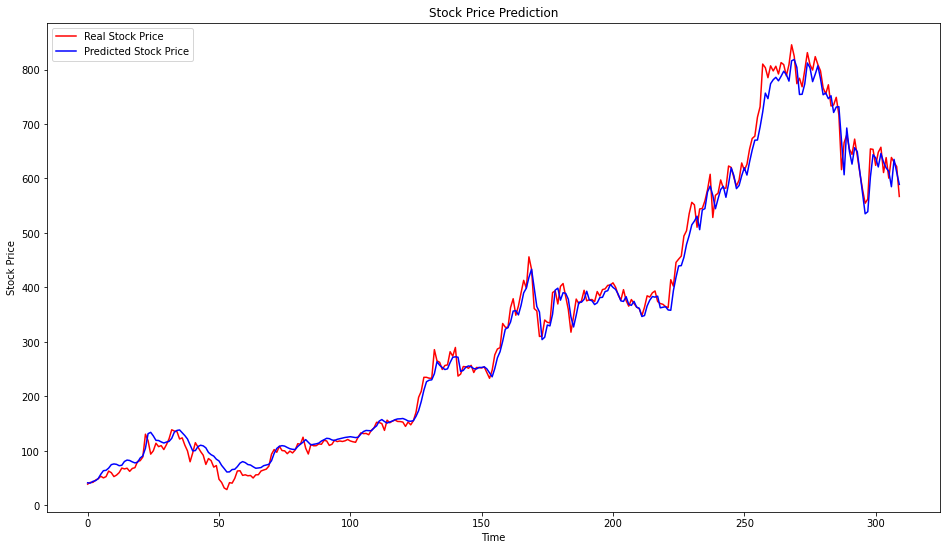

In [35]:
# Visualising the results
plt.figure(figsize=(16,9))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
!kill 9936
%load_ext tensorboard
%tensorboard --logdir my_dir

/bin/bash: line 0: kill: (9936) - No such process


Reusing TensorBoard on port 6006 (pid 644), started 0:07:54 ago. (Use '!kill 644' to kill it.)

<IPython.core.display.Javascript object>